# Load data

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import torch

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"


In [87]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")

In [ ]:
# make lagged volatility variables, 4 of them

for i in range(0, 5):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilities
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, 5):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)


ob_features = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope"
]

for col in ob_features:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    )
dataset = full_data.loc[:, 
                          ['vol' ] + #
                          [f'vol_lag{i}' for i in range(0,5)] +
                          #[f'log_vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in ob_features] + 
                          [f'trend_{col}' for col in ob_features]
                          ]


dataset.loc[:, 'vol_lag0':] = dataset.loc[:, 'vol_lag0':].shift(1)
dataset = dataset.dropna()


In [135]:
def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

In [136]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]


Winsorization does not change the conclusion about what variables are correlated with volatility. Comment out the following cell to skip the winsorization step.

In [137]:
for col in init_training_vola.columns:
    if "trend" in col:
        # init_training_vola = winsorize_trend(init_training_vola, col)
        pass

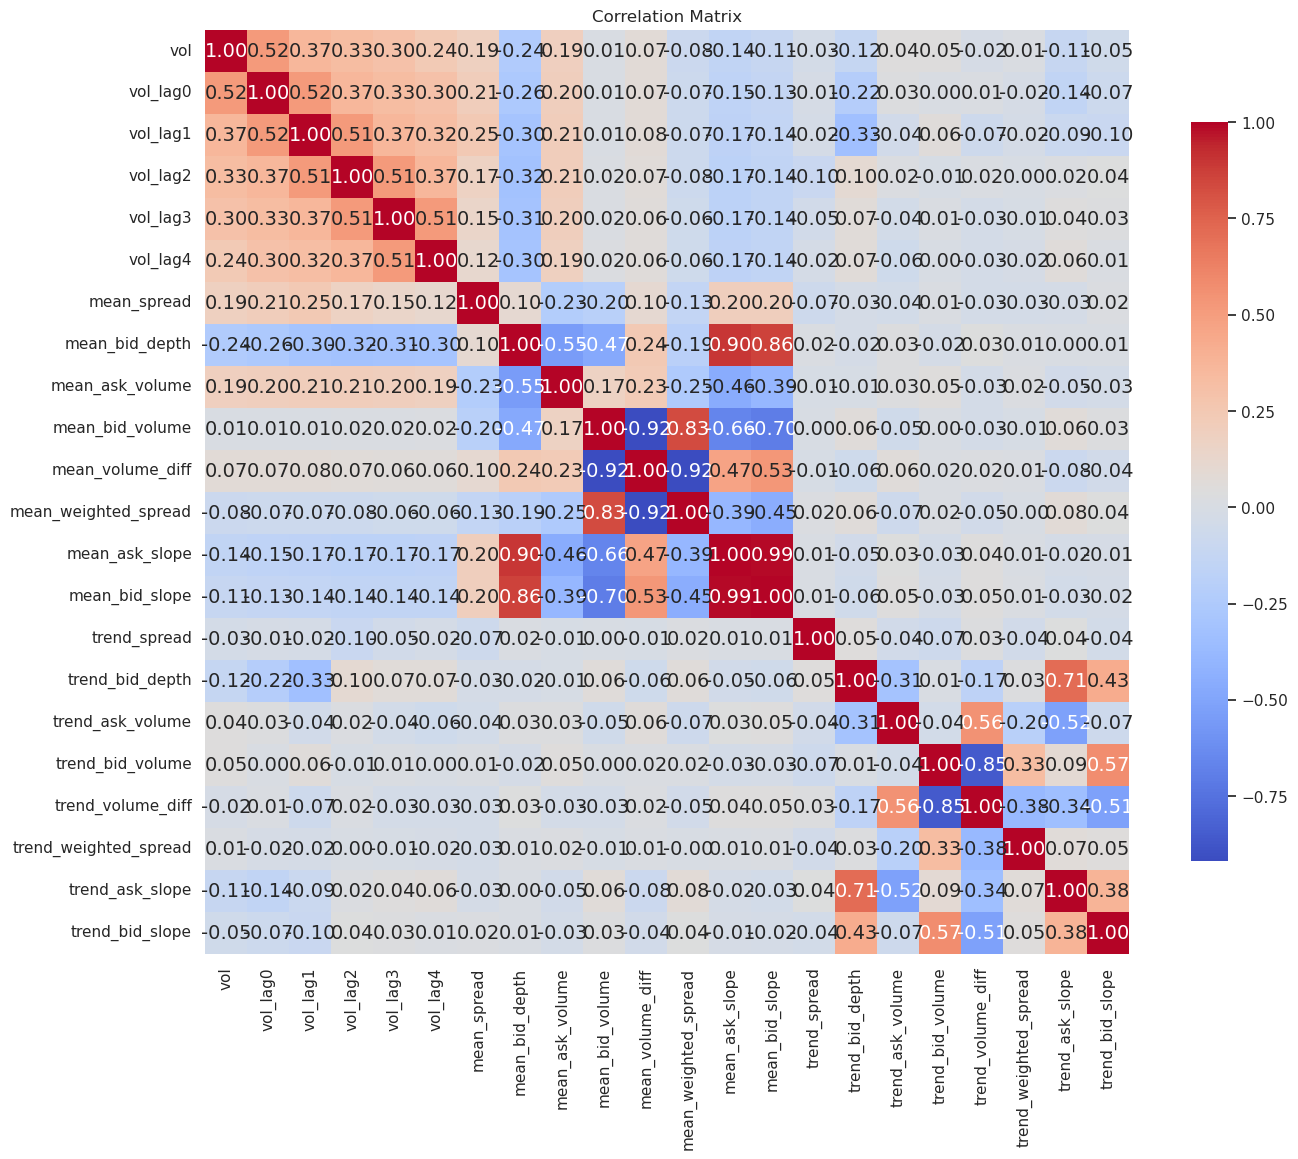

In [138]:
# correlation matrix
corr = init_training_vola.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()



<Axes: >

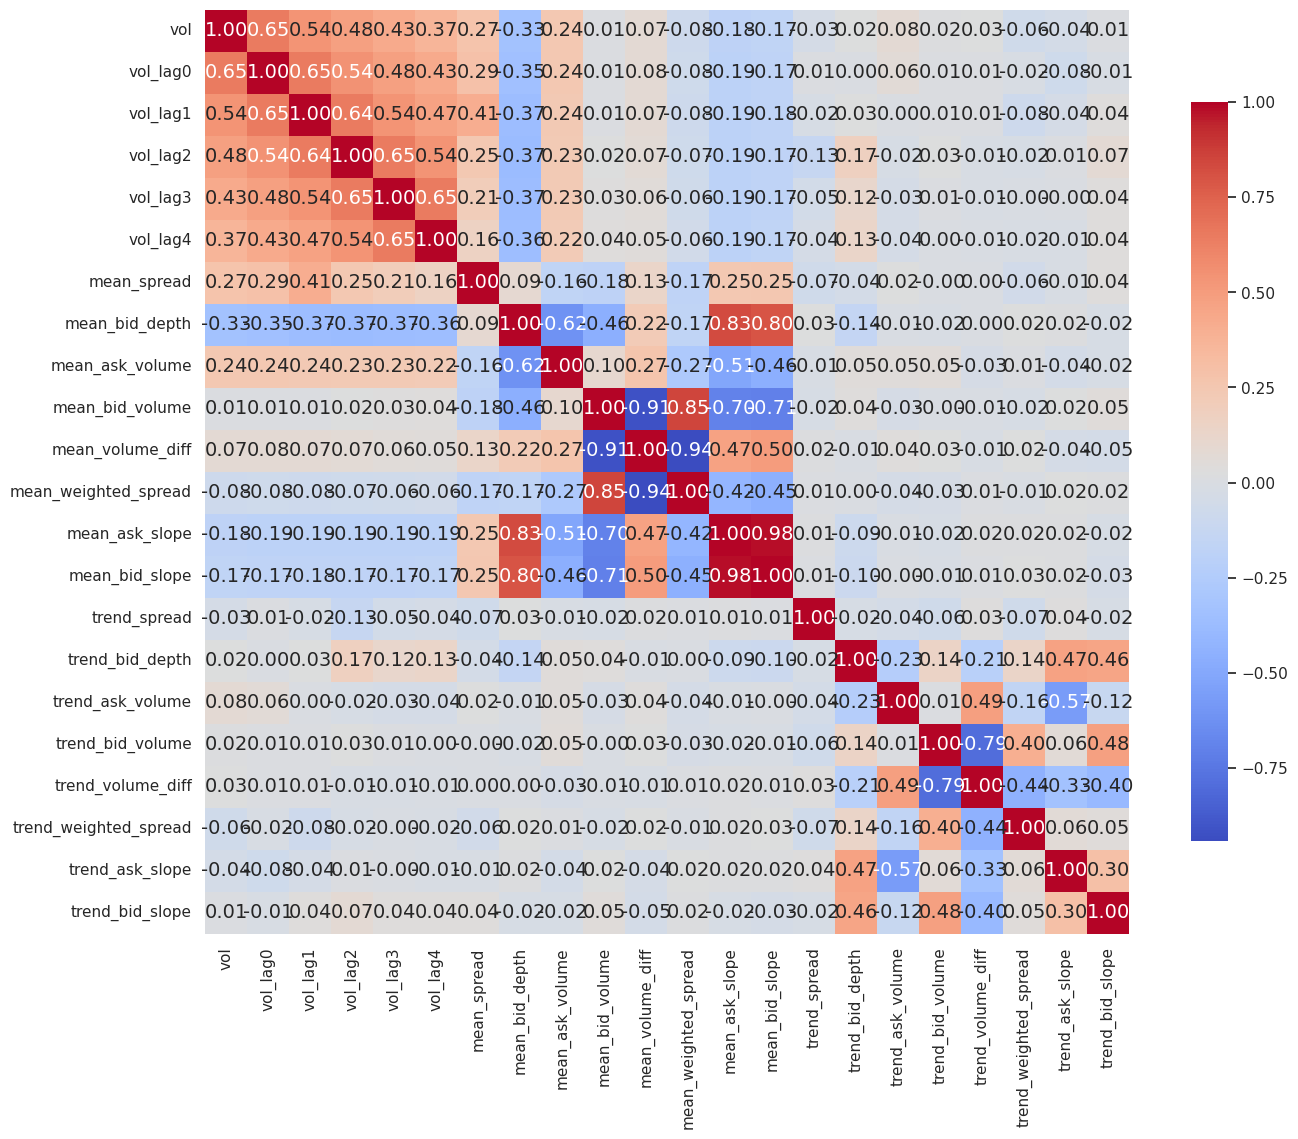

In [139]:
# compute spearman correlation
spearman_corr = init_training_vola.corr(method='spearman')
plt.figure(figsize=(16, 12))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

<Axes: >

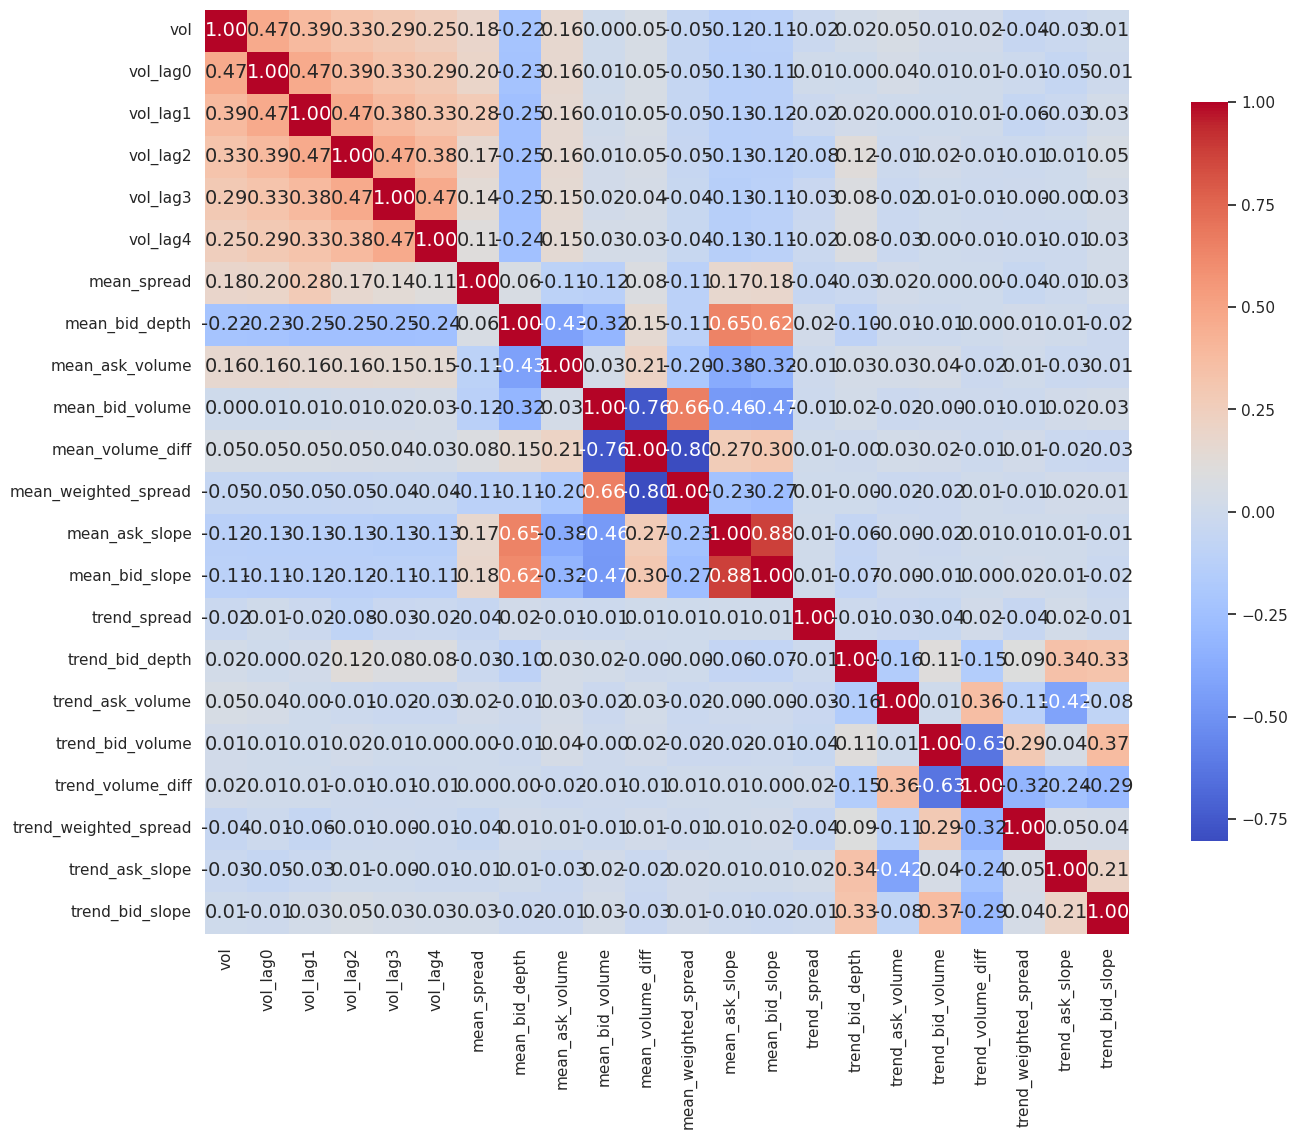

In [140]:
# compute kendall correlation
kendall_corr = init_training_vola.corr(method='kendall')
plt.figure(figsize=(16, 12))
sns.heatmap(kendall_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

The following are features we will keep as exogenous variables in all benchmark models.

In [141]:
ob_features = [
'mean_spread',
'mean_bid_depth',
'mean_ask_volume', 
#'mean_bid_volume',
#'mean_volume_diff', 
#'mean_weighted_spread',
'mean_ask_slope',
'mean_bid_slope']

Since no `trend` variables are used, there is no need for winsorization.

In [ ]:
feats = [
    'vol_lag1', 'vol_lag2', 'vol_lag3', 'vol_lag4','mean_spread',
'mean_bid_depth',
'mean_ask_volume', 
#'mean_bid_volume',
#'mean_volume_diff', 
#'mean_weighted_spread',
'mean_ask_slope',
'mean_bid_slope']

In [143]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training = dataset.loc[:LAST_TRAINING_DATE - pd.Timedelta(days=7), ['vol']+feats]
validation = dataset.loc[LAST_TRAINING_DATE - pd.Timedelta(days=7):LAST_TRAINING_DATE, ['vol']+feats]

# ENet

In [166]:
from sklearn.linear_model import ElasticNet

# tune the model
alphas = [1e-7, 1e-6, 1e-5, 1e-4]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# create a grid of parameters
param_grid = [(alpha, l1_ratio) for alpha in alphas for l1_ratio in l1_ratios]
# create a dataframe to store the results
results = []
# loop through the parameters
for alpha, l1_ratio in tqdm(param_grid):
    # create the model
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)
    # fit the model
    model.fit(init_training[feats], init_training["vol"])
    # make predictions
    y_pred = model.predict(validation[feats])
    # compute the mse and mae
    mse_score = mse(validation["vol"], y_pred)
    mae_score = mae(validation["vol"], y_pred)
    # append the results to the dataframe
    results.append({"alpha": alpha, "l1_ratio": l1_ratio, "mse": mse_score, "mae": mae_score})

100%|██████████| 20/20 [00:00<00:00, 105.50it/s]


In [167]:
results = pd.DataFrame(results)

In [168]:
results.sort_values(by="mse", ascending=True, inplace=True)

In [169]:
results

,alpha,l1_ratio,mse,mae
13,1.000000e-05,0.7,3.730416e-08,0.000124
14,1.000000e-05,0.9,3.730704e-08,0.000124
12,1.000000e-05,0.5,3.730818e-08,0.000124
15,1.000000e-04,0.1,3.731108e-08,0.000125
11,1.000000e-05,0.3,3.731910e-08,0.000123
10,1.000000e-05,0.1,3.733691e-08,0.000123
9,1.000000e-06,0.9,3.733798e-08,0.000123
8,1.000000e-06,0.7,3.734018e-08,0.000123
7,1.000000e-06,0.5,3.734244e-08,0.000123
6,1.000000e-06,0.3,3.734478e-08,0.000123


# RF

In [172]:
from sklearn.ensemble import RandomForestRegressor

# tune the model
n_estimators = [10, 50, 100, 200]
max_depth = [5, 10, 20, 50]
min_samples_split = [2, 5, 10]

# create a grid of parameters
param_grid = [(n, d, m) for n in n_estimators for d in max_depth for m in min_samples_split]
# create a dataframe to store the results
results = []
# loop through the parameters

for n, d, m in tqdm(param_grid):
    # create the model
    model = RandomForestRegressor(n_estimators=n, max_depth=d, min_samples_split=m, random_state=42)
    # fit the model
    model.fit(init_training[feats], init_training["vol"])
    # make predictions
    y_pred = model.predict(validation[feats])
    # compute the mse and mae
    mse_score = mse(validation["vol"], y_pred)
    mae_score = mae(validation["vol"], y_pred)
    # append the results to the dataframe
    results.append({"n_estimators": n, "max_depth": d, "min_samples_split": m, "mse": mse_score, "mae": mae_score})
results = pd.DataFrame(results)
results.sort_values(by="mse", ascending=True, inplace=True)
results

100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


,n_estimators,max_depth,min_samples_split,mse,mae
38,200,5,10,3.797663e-08,0.000130
36,200,5,2,3.835630e-08,0.000131
37,200,5,5,3.846548e-08,0.000131
26,100,5,10,3.879849e-08,0.000132
25,100,5,5,3.890924e-08,0.000133
24,100,5,2,3.894468e-08,0.000133
2,10,5,10,3.900729e-08,0.000136
1,10,5,5,3.903367e-08,0.000137
0,10,5,2,3.916406e-08,0.000136
41,200,10,10,3.941623e-08,0.000138


# XGBM

In [175]:
from xgboost import XGBRegressor

# tune the model
n_estimators = [10, 50, 100, 200]
max_depth = [5, 10, 20, 50]
min_samples_split = [5, 10, 20]


# create a grid of parameters
param_grid = [(n, d, m) for n in n_estimators for d in max_depth for m in min_samples_split]
# create a dataframe to store the results
results = []
# loop through the parameters

for n, d, m in tqdm(param_grid):
    # create the model
    model = RandomForestRegressor(n_estimators=n, max_depth=d, min_samples_split=m, random_state=42)
    # fit the model
    model.fit(init_training[feats], init_training["vol"])
    # make predictions
    y_pred = model.predict(validation[feats])
    # compute the mse and mae
    mse_score = mse(validation["vol"], y_pred)
    mae_score = mae(validation["vol"], y_pred)
    # append the results to the dataframe
    results.append({"n_estimators": n, "max_depth": d, "min_samples_split": m, "mse": mse_score, "mae": mae_score})
results = pd.DataFrame(results)
results.sort_values(by="mse", ascending=True, inplace=True)
results

100%|██████████| 48/48 [00:14<00:00,  3.22it/s]


,n_estimators,max_depth,min_samples_split,mse,mae
38,200,5,20,3.748528e-08,0.000129
26,100,5,20,3.779238e-08,0.000130
37,200,5,10,3.797663e-08,0.000130
44,200,20,20,3.829698e-08,0.000134
47,200,50,20,3.833822e-08,0.000135
41,200,10,20,3.836666e-08,0.000134
36,200,5,5,3.846548e-08,0.000131
35,100,50,20,3.855348e-08,0.000135
32,100,20,20,3.855348e-08,0.000135
14,50,5,20,3.861939e-08,0.000133
